## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.5,0.8]
redice_lr_patient = [4,5,6]

In [8]:
import itertools
results = {}
iters = enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient))
for i, (optim, reduce_factor, reduce_patient) in iters:
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    #model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 4
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 71us/step - loss: 2.2266 - accuracy: 0.2616 - val_loss: 2.1371 - val_accuracy: 0.2117
Epoch 2/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.7446 - accuracy: 0.3932 - val_loss: 1.9801 - val_accuracy: 0.2869
Epoch 3/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6211 - accuracy: 0.4354 - val_loss: 1.8363 - val_accuracy: 0.3654
Epoch 4/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.5458 - accuracy: 0.4597 - val_loss: 1.7236 - val_accuracy: 0.4001
Epoch 5/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4891 - accuracy: 0.4787 - val_loss: 1.6349 - val_accuracy: 0.4327
Epoch 6/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4449 - accuracy: 0.4960 - val_loss: 1.5851 - val_accuracy: 0.4464
Epoch 7/25

Epoch 4/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.8322 - accuracy: 0.3644 - val_loss: 1.9076 - val_accuracy: 0.3299
Epoch 5/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.7700 - accuracy: 0.3842 - val_loss: 1.8410 - val_accuracy: 0.3491
Epoch 6/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.7219 - accuracy: 0.3992 - val_loss: 1.7801 - val_accuracy: 0.3744
Epoch 7/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6832 - accuracy: 0.4123 - val_loss: 1.7446 - val_accuracy: 0.3855
Epoch 8/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.6502 - accuracy: 0.4242 - val_loss: 1.7194 - val_accuracy: 0.3985
Epoch 9/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.6242 - accuracy: 0.4320 - val_loss: 1.6995 - val_accuracy: 0.4062
Epoch 10/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5998 - accuracy: 0.4408 - val_loss: 

50000/50000 [==============================] - 2s 49us/step - loss: 1.6418 - accuracy: 0.4269 - val_loss: 1.7085 - val_accuracy: 0.3960
Epoch 9/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.6156 - accuracy: 0.4353 - val_loss: 1.6887 - val_accuracy: 0.4054
Epoch 10/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5918 - accuracy: 0.4433 - val_loss: 1.6746 - val_accuracy: 0.4084
Epoch 11/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5703 - accuracy: 0.4515 - val_loss: 1.6596 - val_accuracy: 0.4172
Epoch 12/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5493 - accuracy: 0.4588 - val_loss: 1.6528 - val_accuracy: 0.4216
Epoch 13/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5318 - accuracy: 0.4659 - val_loss: 1.6451 - val_accuracy: 0.4252
Epoch 14/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5162 - accuracy: 0.4724 - val_loss: 1.6328 

50000/50000 [==============================] - 2s 48us/step - loss: 1.5719 - accuracy: 0.4533 - val_loss: 1.6740 - val_accuracy: 0.4132
Epoch 13/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.5538 - accuracy: 0.4600 - val_loss: 1.6615 - val_accuracy: 0.4231
Epoch 14/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.5365 - accuracy: 0.4650 - val_loss: 1.6516 - val_accuracy: 0.4250
Epoch 15/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.5216 - accuracy: 0.4699 - val_loss: 1.6446 - val_accuracy: 0.4265
Epoch 16/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5067 - accuracy: 0.4765 - val_loss: 1.6362 - val_accuracy: 0.4298
Epoch 17/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.4923 - accuracy: 0.4818 - val_loss: 1.6307 - val_accuracy: 0.4334
Epoch 18/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4798 - accuracy: 0.4854 - val_loss: 1.6270

50000/50000 [==============================] - 2s 44us/step - loss: 1.4826 - accuracy: 0.4815 - val_loss: 1.6281 - val_accuracy: 0.4293
Epoch 17/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.4677 - accuracy: 0.4878 - val_loss: 1.6164 - val_accuracy: 0.4280
Epoch 18/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4544 - accuracy: 0.4910 - val_loss: 1.6146 - val_accuracy: 0.4321
Epoch 19/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.4420 - accuracy: 0.4982 - val_loss: 1.6067 - val_accuracy: 0.4349
Epoch 20/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4303 - accuracy: 0.5004 - val_loss: 1.6006 - val_accuracy: 0.4364
Epoch 21/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4184 - accuracy: 0.5055 - val_loss: 1.5935 - val_accuracy: 0.4395
Epoch 22/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.4070 - accuracy: 0.5096 - val_loss: 1.5902

50000/50000 [==============================] - 2s 48us/step - loss: 1.4066 - accuracy: 0.5151 - val_loss: 1.5958 - val_accuracy: 0.4480
Epoch 19/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.3958 - accuracy: 0.5179 - val_loss: 1.5928 - val_accuracy: 0.4480
Epoch 20/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.3851 - accuracy: 0.5230 - val_loss: 1.5876 - val_accuracy: 0.4524
Epoch 21/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.3754 - accuracy: 0.5267 - val_loss: 1.5836 - val_accuracy: 0.4544
Epoch 22/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.3652 - accuracy: 0.5306 - val_loss: 1.5802 - val_accuracy: 0.4557
Epoch 23/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.3564 - accuracy: 0.5331 - val_loss: 1.5759 - val_accuracy: 0.4563
Epoch 24/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.3469 - accuracy: 0.5372 - val_loss: 1.5734

50000/50000 [==============================] - 3s 53us/step - loss: 1.3330 - accuracy: 0.5416 - val_loss: 1.5476 - val_accuracy: 0.4640
Epoch 23/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.3244 - accuracy: 0.5450 - val_loss: 1.5412 - val_accuracy: 0.4627
Epoch 24/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.3159 - accuracy: 0.5492 - val_loss: 1.5505 - val_accuracy: 0.4650
Epoch 25/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3067 - accuracy: 0.5531 - val_loss: 1.5406 - val_accuracy: 0.4669
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 5
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.2651 - accuracy: 0.2598 - val_loss: 2.1336 - val_accuracy: 0.2287
Epoch 2/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.8404 - accuracy: 0.3640 - val_loss: 2.0119 - val_accuracy: 0.2815
Epoch 3/25
50000/

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 59us/step - loss: 2.1663 - accuracy: 0.2761 - val_loss: 2.1320 - val_accuracy: 0.2497
Epoch 2/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.8101 - accuracy: 0.3718 - val_loss: 2.0003 - val_accuracy: 0.3173
Epoch 3/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.7108 - accuracy: 0.4072 - val_loss: 1.8881 - val_accuracy: 0.3555
Epoch 4/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.6517 - accuracy: 0.4247 - val_loss: 1.8021 - val_accuracy: 0.3807
Epoch 5/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.6102 - accuracy: 0.4404 - val_loss: 1.7421 - val_accuracy: 0.3956
Epoch 6/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.5782 - accuracy: 0.4533 - val_loss: 1.6864 - val_accuracy: 0.4110
Epoch 7/25
50000/50000 [==============================] - 2s 46us/st

Epoch 5/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6322 - accuracy: 0.4334 - val_loss: 1.7342 - val_accuracy: 0.4087
Epoch 6/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5968 - accuracy: 0.4462 - val_loss: 1.6834 - val_accuracy: 0.4180
Epoch 7/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.5684 - accuracy: 0.4566 - val_loss: 1.6541 - val_accuracy: 0.4245
Epoch 8/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.5440 - accuracy: 0.4645 - val_loss: 1.6280 - val_accuracy: 0.4350
Epoch 9/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5222 - accuracy: 0.4718 - val_loss: 1.6166 - val_accuracy: 0.4364
Epoch 10/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.5026 - accuracy: 0.4801 - val_loss: 1.6064 - val_accuracy: 0.4398
Epoch 11/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4854 - accuracy: 0.4872 - val_loss:

Epoch 8/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.3912 - accuracy: 0.5196 - val_loss: 1.5633 - val_accuracy: 0.4465
Epoch 9/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.3562 - accuracy: 0.5334 - val_loss: 1.5456 - val_accuracy: 0.4589
Epoch 10/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.3239 - accuracy: 0.5435 - val_loss: 1.5277 - val_accuracy: 0.4608
Epoch 11/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.2963 - accuracy: 0.5558 - val_loss: 1.5184 - val_accuracy: 0.4665
Epoch 12/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2692 - accuracy: 0.5656 - val_loss: 1.5087 - val_accuracy: 0.4675
Epoch 13/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2438 - accuracy: 0.5757 - val_loss: 1.5072 - val_accuracy: 0.4697
Epoch 14/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2188 - accuracy: 0.5842 - val_lo

50000/50000 [==============================] - 3s 50us/step - loss: 1.6812 - accuracy: 0.4180 - val_loss: 1.7405 - val_accuracy: 0.3948
Epoch 12/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.6565 - accuracy: 0.4271 - val_loss: 1.7270 - val_accuracy: 0.4036
Epoch 13/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.6353 - accuracy: 0.4334 - val_loss: 1.7195 - val_accuracy: 0.4040
Epoch 14/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.6161 - accuracy: 0.4387 - val_loss: 1.7062 - val_accuracy: 0.4088
Epoch 15/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.5977 - accuracy: 0.4443 - val_loss: 1.7005 - val_accuracy: 0.4124
Epoch 16/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.5809 - accuracy: 0.4506 - val_loss: 1.6924 - val_accuracy: 0.4105
Epoch 17/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.5659 - accuracy: 0.4562 - val_loss: 1.6834

50000/50000 [==============================] - 3s 54us/step - loss: 1.5935 - accuracy: 0.4454 - val_loss: 1.6854 - val_accuracy: 0.4135
Epoch 16/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.5764 - accuracy: 0.4532 - val_loss: 1.6734 - val_accuracy: 0.4168
Epoch 17/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.5605 - accuracy: 0.4585 - val_loss: 1.6650 - val_accuracy: 0.4191
Epoch 18/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5450 - accuracy: 0.4642 - val_loss: 1.6554 - val_accuracy: 0.4251
Epoch 19/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.5305 - accuracy: 0.4681 - val_loss: 1.6498 - val_accuracy: 0.4247
Epoch 20/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5171 - accuracy: 0.4743 - val_loss: 1.6446 - val_accuracy: 0.4253
Epoch 21/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.5046 - accuracy: 0.4780 - val_loss: 1.6388

50000/50000 [==============================] - 2s 50us/step - loss: 1.5354 - accuracy: 0.4661 - val_loss: 1.6668 - val_accuracy: 0.4184
Epoch 20/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.5200 - accuracy: 0.4724 - val_loss: 1.6574 - val_accuracy: 0.4198
Epoch 21/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.5082 - accuracy: 0.4771 - val_loss: 1.6526 - val_accuracy: 0.4223
Epoch 22/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.4949 - accuracy: 0.4820 - val_loss: 1.6446 - val_accuracy: 0.4210
Epoch 23/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.4825 - accuracy: 0.4843 - val_loss: 1.6372 - val_accuracy: 0.4267
Epoch 24/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.4712 - accuracy: 0.4904 - val_loss: 1.6291 - val_accuracy: 0.4329
Epoch 25/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.4602 - accuracy: 0.4938 - val_loss: 1.6244

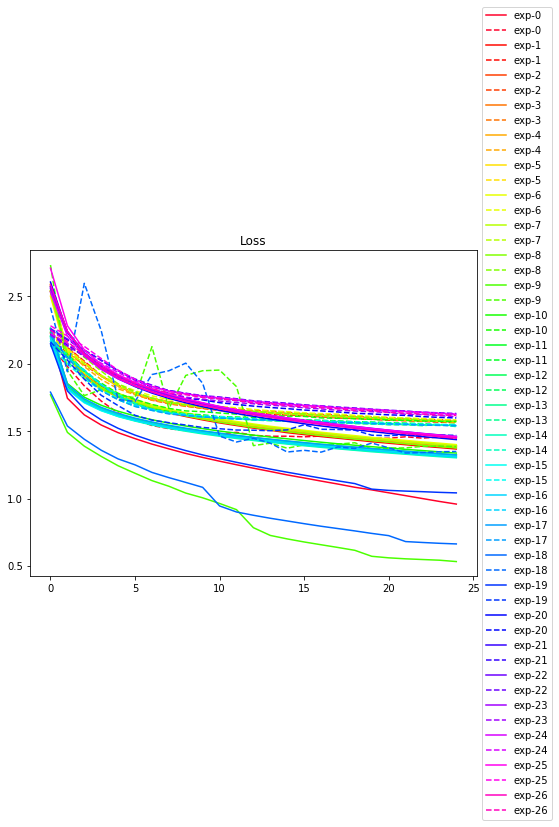

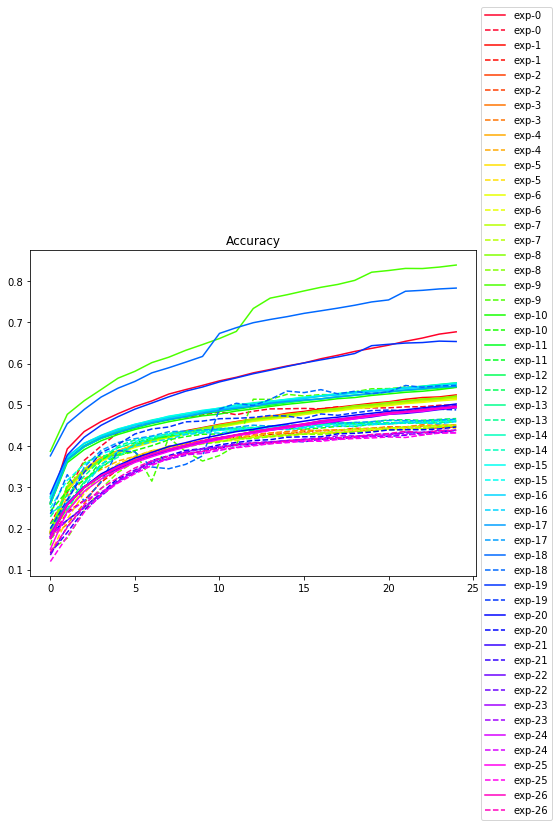

In [9]:

NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()